# M5 Forecasting

### Abstract
> Forecasting, the prediction of future events from past data, is central to decision-making in virtually all technical domains. For instance, predicting product sales in retail, forecasting energy demand, or anticipating customer churn, all have tremendous value across different industries. However, the landscape of forecasting techniques is as diverse as it is useful, and different techniques and expertise are adapted to different types and sizes of data.
>
> Content: EDA, data preparation, feature engineering, statistical modeling (e.g., STL, ARIMA) and machine learning (e.g., decision forests) modeling, meta-modeling (e.g., hierarchical and relational modeling, ensembles, resource models), and how to safely evaluate such temporal models.

In [1]:
!pip install gdown 

In [2]:
!apt-get -qq install -y graphviz && pip install pydot

Selecting previously unselected package fonts-liberation.
(Reading database ... 69943 files and directories currently installed.)
Preparing to unpack .../00-fonts-liberation_1%3a1.07.4-11_all.deb ...
Unpacking fonts-liberation (1:1.07.4-11) ...
Selecting previously unselected package libann0.
Preparing to unpack .../01-libann0_1.1.2+doc-7build1_amd64.deb ...
Unpacking libann0 (1.1.2+doc-7build1) ...
Selecting previously unselected package libcdt5:amd64.
Preparing to unpack .../02-libcdt5_2.42.2-3build2_amd64.deb ...
Unpacking libcdt5:amd64 (2.42.2-3build2) ...
Selecting previously unselected package libcgraph6:amd64.
Preparing to unpack .../03-libcgraph6_2.42.2-3build2_amd64.deb ...
Unpacking libcgraph6:amd64 (2.42.2-3build2) ...
Selecting previously unselected package libgts-0.7-5:amd64.
Preparing to unpack .../04-libgts-0.7-5_0.7.6+darcs121130-4_amd64.deb ...
Unpacking libgts-0.7-5:amd64 (0.7.6+darcs121130-4) ...
Selecting previously unselected package libpathplan4:amd64.
Preparing t

In [3]:
#@title Imports

import gc
import re
from collections import defaultdict
from typing import Dict, Tuple, List, Optional, NamedTuple, Union

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow_decision_forests as tfdf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from tqdm import tqdm
import pydot
from IPython.display import Image

plt.style.use("default")
plt.rcParams["figure.figsize"] = (12, 3)

2024-04-12 05:26:18.355587: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 05:26:18.974471: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 05:26:19.962720: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 05:26:23.915779: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Intro

Forecasting is a crucial aspect of many industries and fields, including finance, healthcare, manufacturing, and transportation. It helps organizations make informed decisions by anticipating future trends and outcomes, which can improve efficiency and reduce costs.

The landscape of forecasting techniques is as diverse as it is useful. Different techniques exist for different types (e.g., time sequences, time series, transactions) and amounts (e.g., 10 observations, 10B observations) of data, as well as for different type of predictions.

On small time series dataset, statistical models such as [ARIMA](https://otexts.com/fpp3/arima.html) and [Exponential Smoothing](https://otexts.com/fpp3/expsmooth.html) are well suited. On larger datasets where more complex models can be learned, deep learning and [decision forests](https://en.wikipedia.org/wiki/Random_forest) methods are commonly used. In this session, we will demonstrate the use of one statistical model (ARIMA) and a more powerful general purpose model (decision forests).

Data-preparation plays an important role in forecasting. Feature engineering is useful to inject expert knowledge in models when only a small amount of data is available.

Feature engineering is also important on large datasets. It is used to extend the power of expression of forecasting models. For example, while a [feed-forward neural network](https://en.wikipedia.org/wiki/Feedforward_neural_network) is not able to consume [relational data](https://en.wikipedia.org/wiki/Relational_database), preprocessing (called "flattening" in this case) relational data into tabular data can be beneficial for the modeling task.

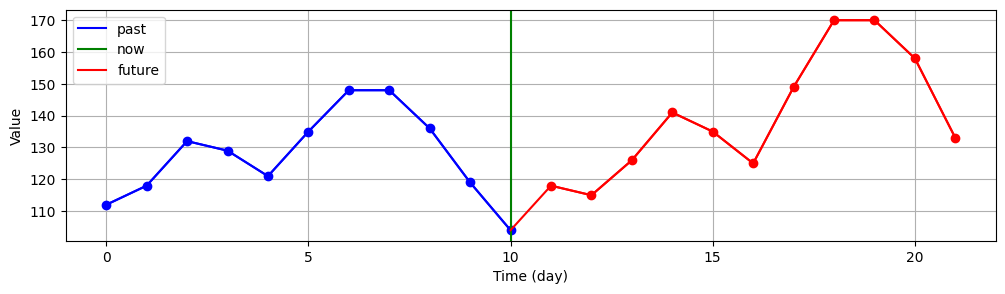

In [4]:
#@title Forecast
past_data = [112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104]
past_time = [i for i in range(len(past_data))]
now_time = len(past_time) - 1
future_data = [118, 115, 126, 141, 135, 125, 149, 170, 170, 158, 133]
future_time = [i + len(past_time) for i in range(len(future_data))]

plot_xlim = [-1, future_time[-1] + 1]


plt.plot(past_time, past_data, color="blue", label="past")
plt.plot(past_time, past_data, color="blue", marker="o")
plt.axvline(x=now_time, color="green", label="now")
plt.plot(future_time, future_data, color="red", marker="o")
# add last past value in order to join future and past line
plt.plot([past_time[-1]] + future_time, [past_data[-1]] + future_data, color="red", label="future")


plt.xlabel("Time (day)")
plt.ylabel("Value")
plt.xlim(plot_xlim)
plt.legend()
plt.grid()
plt.show()

## Forecasting on Timeseries

Let's start simple. A (univariate) time series (TS) is a sequence of numerical values sampled at a constant rate (e.g., once a day). The only variable is the time, often represented by 𝑡.

A TS can be represented as a plot where the horizontal axis is the time, and the vertical axis is the TS value.

**To go deeper:** The time $t$ of an observation is not necessarily the time of occurrence of the observed phenomenon. It can also be the time where this observation becomes available for decision making. For example, if the [Curiosity mars rover](https://en.wikipedia.org/wiki/Curiosity_(rover)) makes a measurement at a certain time, this measurement can only be used for decision making on earth between 5 and 20 minutes later because of the speed of light propagation.

### Next step forecast

The simplest and most direct type of forecasting is the "next step" prediction. The objective is to predict the next value $s[t+1]$ (orange dot).

The prediction can be a single point such as the expected value, a distribution, or a statistic of this distribution (e.g. first quantile). It is common to predict both the expected value and the confidence boundaries on the prediction.

**Example of next-step forecast:** How much product will be solved tomorow?

### Multi-steps forecast

More complex is the forecasting of the next $h>1$ steps: $\{ s[t+i]\ |\ i \in [1, h] \}$

*Note: $h$ stands for "horizon".*

### Aggregated forecast

In some cases, predicting the aggregated values of the next steps is easier and equally useful for planning.

For example, we can predict the sum or the maximum of the TS in the next h days:
$$
\sum_{i=1}^h s[t+i]
$$
or
$$
\max_{i \in [1, h]} s[t+i]
$$

**Concrete example:** predict the sum of sales in the next 28 days.

### Conditional forecast

Finally, it is sometimes enough to only predict a condition on the data. For example, we can predict if the value will be greater than a threshold $\tau$ in the next $h$ steps: $\ s[t+i] \ge \tau$ for $i \in [1,h]\ $.

**Concrete example:** Will the heart rate of the patient go under 5 beats per seconds in the next 6h.

In [5]:
EXECUTION_MODE = "MINI"

# Here you can see the available config and their parameter values.
#
# num_trees: Number of decision trees trained in each model.
# num_items / num_stores: Number of selected items /stores in the dataset.
# num_horizons: How many steps to forecast in multi-step forecast.

available_configs = {
    "TOY": {
        "num_trees": 20,
        "num_items": 3,
        "num_stores": 3,
        "num_horizons": 2,
    },
    "MINI": {
        "num_trees": 75,
        "num_items": 5,
        "num_stores": 5,
        "num_horizons": 7,
    },
    "FULL": {
        "num_trees": 1000,
        "num_items": None,
        "num_stores": None,
        "num_horizons": 28,
    }
}

config = available_configs[EXECUTION_MODE]
print(f"{config=}")

config={'num_trees': 75, 'num_items': 5, 'num_stores': 5, 'num_horizons': 7}


## The data: The M5 Competition

The [M5 Competition](https://www.kaggle.com/competitions/m5-forecasting-accuracy/overview) is the 2020 instance of the [Makridakis Forecasting Competitions](https://en.wikipedia.org/wiki/Makridakis_Competitions). The objective of this competition is to forecast the next 28 days of sales of 3k individual items in 10 different Walmart stores.

Walmart's data possesses a strong hierarchical structure, since each item belongs to a certain category and department, and each store to a certain state.

This means that, besides the 30k individual low-level time series corresponding to the daily sales of a specific item in a specific store (which we'll be referring to as an "item-store" or "level 12" time series), the data can be aggregated in multiple ways to generate a total of 42,840 time series to be forecasted, as shown in the images below.

In this notebook, we will stick to only predicting the sales of item-store series, though the data's hierarchical structure will come in handy in the feature engineering stage.

Details such as the [competition's guide](https://github.com/Mcompetitions/M5-methods/blob/master/M5-Competitors-Guide.pdf) and [Makridakis' analysis of the winning entries](https://www.researchgate.net/publication/344487258_The_M5_Accuracy_competition_Results_findings_and_conclusions) are available online.

<img src="https://drive.google.com/uc?export=view&id=1ssPXZf1uVtNnbbjaaEEqpx4ZmhQobmSE" width=800/>
<img src="https://drive.google.com/uc?export=view&id=1jBT0pPcSWf8n5bJkZ1G7y_glrQcrYKoI" width=800/>

Source: [The M5 Accuracy competition: Results, findings and conclusions](https://www.researchgate.net/publication/344487258_The_M5_Accuracy_competition_Results_findings_and_conclusions)

## Load the dataset

Let's download and unzip the competition's dataset.

In [6]:
!gdown 'https://docs.google.com/uc?export=download&id=1NYHXmgrcXg50zR4CVWPPntHx9vvU5jbM&confirm=t' -O ../../data/
!unzip -o ../../data/m5-forecasting-accuracy.zip -d ../../data/
!rm ../../data/m5-forecasting-accuracy.zip

Downloading...
From: https://docs.google.com/uc?export=download&id=1NYHXmgrcXg50zR4CVWPPntHx9vvU5jbM&confirm=t
To: /notebooks/crypto-quant-lab/data/m5-forecasting-accuracy.zip
100%|███████████████████████████████████████| 48.0M/48.0M [00:00<00:00, 115MB/s]
Archive:  ../../data/m5-forecasting-accuracy.zip
  inflating: ../../data/calendar.csv  
  inflating: ../../data/sales_train_evaluation.csv  
  inflating: ../../data/sales_train_validation.csv  
  inflating: ../../data/sample_submission.csv  
  inflating: ../../data/sell_prices.csv  


The dataset is composed of 5 csv files:

- `sales_train_evaluation`: The history of item sales.
- `calendar.csv`: Dates and calendar events.
- `sell_prices.csv`: The history of the item prices.
- `sales_train_validation`: Another set of sales.
- `sample_submission`: An example of submission for the competition.


Following are the column names used in the dataset. To minimize errors, we recommend using these variables.

In [7]:
# Identifier of a sales timeseries.
# This is the series of sales values of a given ITEM, in a given STORE.
ID = "id"

ITEM = "item_id" # Identifier of the item
STORE = "store_id" # Identifier of the store
DEPT = "dept_id" # Identifier of the item's department
CAT = "cat_id" # Identifier of the item's category
STATE = "state_id" # Identifier of the store's state

DAY = "d" # Identifier of the day, sequential number from day 1 to 1941
DATE = "date" # The calendar date each day corresponds to
SALES = "sales" # The sales value for an ID on a certain DAY
PRED = "sales_pred" # The predicted sales value for an ID on a certain DAY

Let's load and take a look at the historical sales in  `sales_train_evaluation.csv`. Each row contains the sales of a item+store pair (i.e. for a given item in a given store). Sales are aggregated per day. Each day, indexed between 1 and 1914 (5+ years), is stored in a different column.

> Add blockquote

> Add blockquote





**Note:** Most of the values in this dataset are strings (e.g. stores are `CA_1`, `CA_2`, ...) with few unique values. To limit the memory footprint, we will load those columns as [Pandas' categorical dtype](https://pandas.pydata.org/docs/user_guide/categorical.html).

In [13]:
raw_sales = pd.read_csv(
    "../../data/sales_train_evaluation.csv",
    dtype={
        ID: "category",
        ITEM: "category",
        DEPT: "category",
        CAT: "category",
        STORE: "category",
        STATE: "category",
    }
)

print("Memory Usage")
print(raw_sales.info())

print("First 5 rows:")
raw_sales.head()

Memory Usage
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: category(6), int64(1941)
memory usage: 453.1 MB
None
First 5 rows:


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


##  Explore the dataset

Looking at the data is the first step of any forecasting exercise. Although we won't do a thorough exploratory data analysis in this codecamp, lets take a quick look at some plots to get a grasp on the data we're dealing with.

Let's plot the first three series:

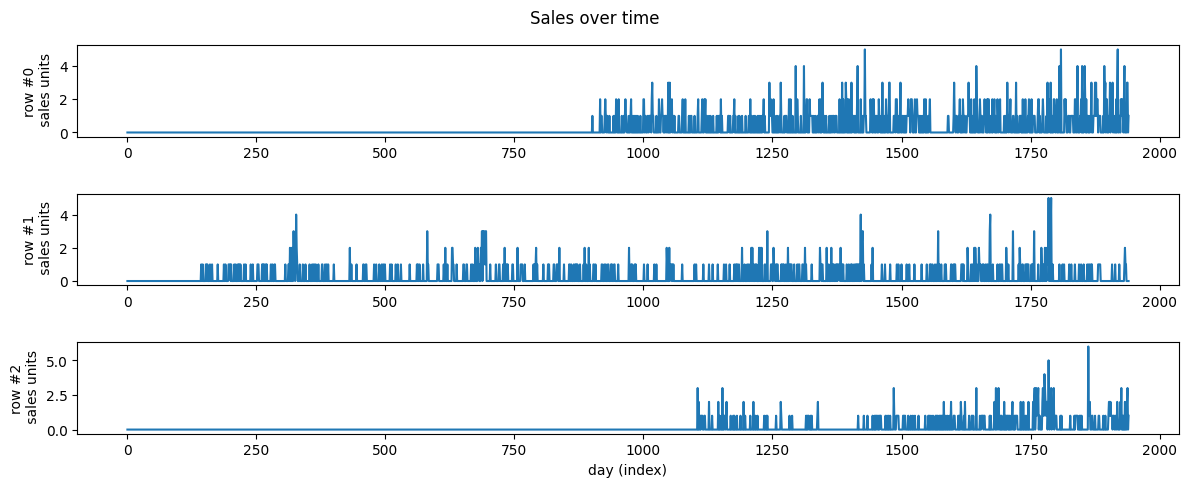

In [14]:
#@title
num_plots = 3
plt.figure(figsize=(12,2 * num_plots))

d_cols = list(raw_sales.filter(regex="d_"))

for row_idx in range(num_plots):
  # "ts" refers to "timeseries".
  sales_ts = raw_sales.iloc[row_idx][d_cols].to_numpy()

  plt.subplot(num_plots+1, 1, row_idx+1)
  plt.plot(sales_ts)
  plt.ylabel(f"row #{row_idx}\n sales units")

plt.suptitle("Sales over time")
plt.xlabel("day (index)")
plt.tight_layout(h_pad=1)
plt.show()

### Question

1. What insights or conclusions do you draw from the plots above?

<Axes: title={'center': 'HOBBIES_1_001_CA_1_evaluation'}>

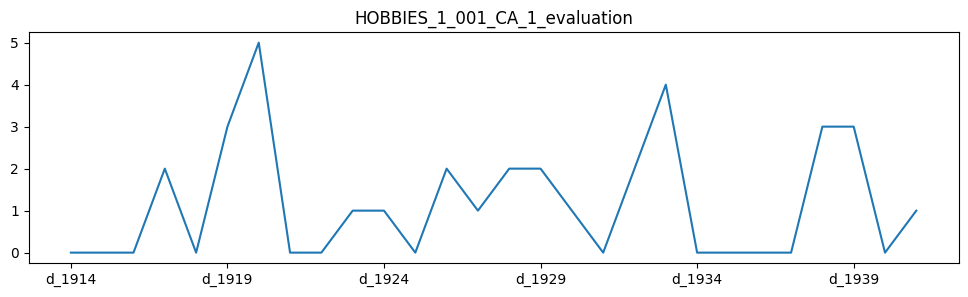

In [15]:
example_id = "HOBBIES_1_001_CA_1_evaluation"

# select the sales of our example item
example_ts = raw_sales[(raw_sales[ID] == example_id)][d_cols].squeeze()

# plot the last 28 days of sales.
example_ts[-28:].plot.line(title=example_id)

At the item-store level, sales can be very sparse for non popular items. For example, in the plot above, there were no sales in about half the displayed days.

It can be interesting to look at aggregated sales according to different dimensions. For example, the following plot shows the sales for the store `CA_1`, once you've completed the exercise of filling the code for `aggregate_sales_by_store`.

In [ ]:
def aggregate_sales_by_store(sales: pd.DataFrame) -> pf.Datawoemd